# AI Is Changing Computer Graphics
## Ross Woleben

This notebook is a supplement to the [AI Is Changing Computer Graphics](https://www.rosswoleben.com/projects/ai-cg) post on my website. This notebook explains resolution and render scaling, provides additional commentary omitted from the main post, and provides a mathematical analogy of how you can restore detail to a low-resolution image.

## DLSS Intuition: Render Scale and Single-Frame Super Resolution

#### Resolution

There are two primary types of resolutions in which video games are rendered and displayed: an industry or game-specified standard, such as 1080p (1920x1080 pixels), and the native resolution of the display device (TV or monitor) the game is played on, typically ranging from 1080p to 4K (3840x2160 pixels). Native resolution refers to the pre-set and usually highest quality setting on a display device, and most modern PC games will instruct your computer to render the game at this resolution by default.  

If you are displaying a video game at 1080p resolution, your computer renders 2,073,600 pixels (1920 times 1080) to the screen. If you display the game on a device with a 4K native resolution, your computer will instead render 8,294,400 pixels (3840 times 2160) - 4 times as many pixels as a 1080p monitor. This increased pixel count presents a tradeoff between game performance (most noticeable in frame rates) and visual quality: Since your computer is rendering 4 times the pixels, it will have higher detailed frames, but won't be able to render the frames as quickly as it would on a lower resolution. This tradeoff should be fairly intuitive: it will take a longer time or require more compute power to render more pixels. 

#### Render Scale

To maneuver the tradeoff between performance and image quality, some PC games have a graphics setting called "render scale" or "resolution scale," which changes the resolution at which the game's engine renders the graphics. By selecting a smaller render scale, you can sacrifice some of the sharpness in image quality for a smoother frame rate. Conversely, if you can run a game at a very high frame rate, you can adjust the render scale to improve image sharpness in exchange for a lower framerate. In my opinion, this second option is not that helpful, but using a smaller render scale is one of the fundamental ideas behind DLSS.

If you have the render scale set to 50%, your computer will only need to render 50% percent of the pixels that would've been needed for the native resolution. With a render scale set to 50% on a 1080p native resolution, you only render 1,036,800 pixels instead of 2,073,600 pixels, which comes out to a 764p resolution (1358x764 pixels). The lower-resolution frames are then upscaled to fit the dimensions of the display device. 

If you have the render scale set to 150%, your computer will need to render 150% percent of the pixels that would've been needed for your native resolution. With a render scale set to 150% on a 1080p native resolution, you render 3,110,400 pixels instead of rendering 2,073,600 pixels, which comes out to a 1323p resolution (2352x1323 pixels). However, in this case, the display device has a maximum resolution of 1080p so the high-resolution frames are downsampled to fit the dimensions of the display device. 

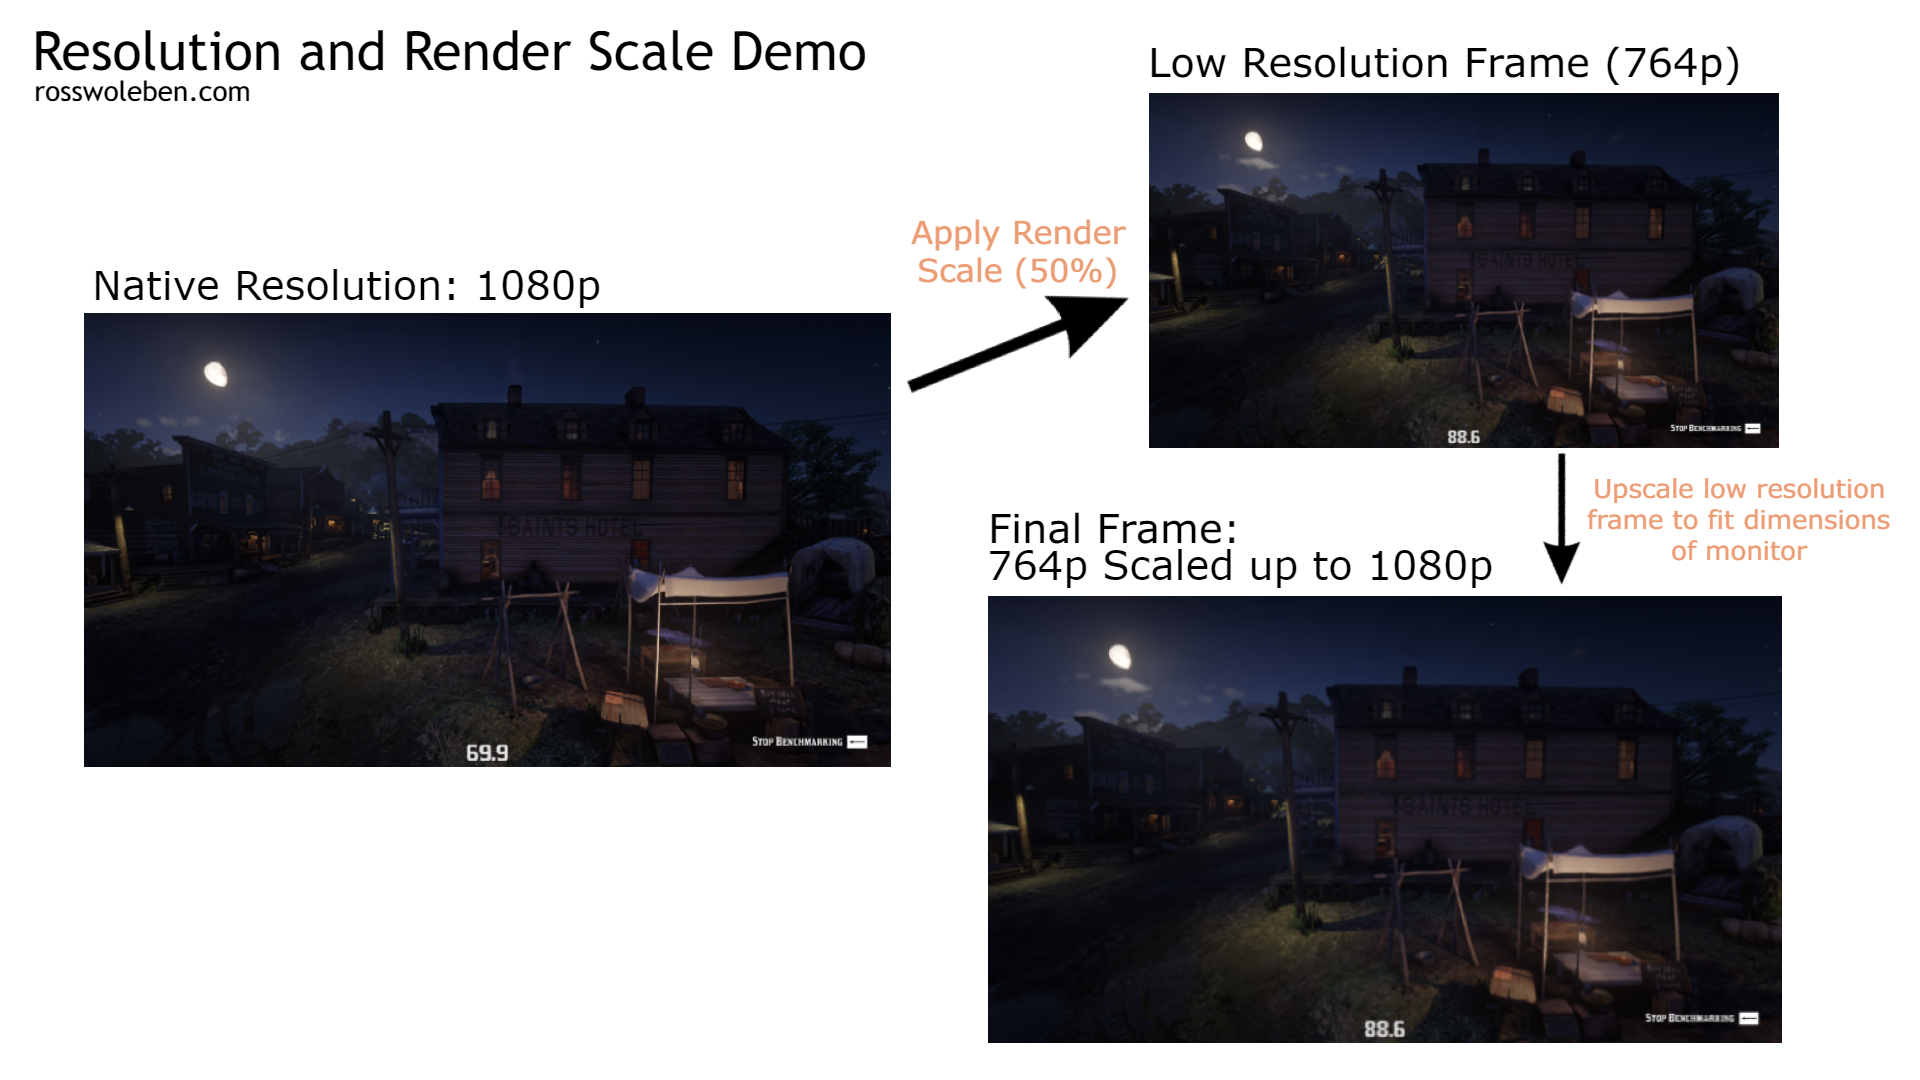

There are several different methods of upscaling or downscaling; some popular methods include [bicubic interpolation, Lanczos resampling, and spline interpolation](https://en.wikipedia.org/wiki/Image_scaling). For more a visual explanation of image scaling and super-resolution, watch ["How Super Resolution Works" by Leo Isikdogan on Youtube](https://www.youtube.com/watch?v=KULkSwLk62I).

The fundamental idea of DLSS is rooted in the concept of reducing the render scale. However, DLSS attempts to solve a much more complex problem as it is also trying to minimize the amount of detail lost. Unfortunately, the algorithms mentioned above are not as good at this task, inspiring the necessity of deep learning techniques to smoothly generate high-quality frames.    

The following code uses the formula from [omnicalculator.com](https://www.omnicalculator.com/other/resolution-scale#how-to-manually-scale-or-resize-a-resolution-using-the-formula) to scale resolution according to a percentage (and maintains aspect ratio).

In [1]:
import math

def calc_render_scale(original_resolution: tuple, scaling_factor_percentage :float):
    original_pixel_count = original_resolution[0] * original_resolution[1]
    scaled_pixel_count = original_pixel_count * scaling_factor_percentage / 100
    
    width_ratio = original_resolution[1]/original_resolution[0]
    height_ratio = original_resolution[0]/original_resolution[1]
    
    width_scaled = math.sqrt( scaled_pixel_count / width_ratio  )
    height_scaled = math.sqrt( scaled_pixel_count / height_ratio )
    
    scaled_resolution = (round(width_scaled), round(height_scaled))
    
    print(f"Original Resolution: {original_resolution[0]}x{original_resolution[1]} for a total of {original_pixel_count} pixels")
    print(f"Final    Resolution: {scaled_resolution[0]}x{scaled_resolution[1]} for a total of {round(scaled_pixel_count)} pixels when scaled at {scaling_factor_percentage}%")
    
    return

In [2]:
calc_render_scale((1920, 1080), 50)
print()
calc_render_scale((1920, 1080), 150)

Original Resolution: 1920x1080 for a total of 2073600 pixels
Final    Resolution: 1358x764 for a total of 1036800 pixels when scaled at 50%

Original Resolution: 1920x1080 for a total of 2073600 pixels
Final    Resolution: 2352x1323 for a total of 3110400 pixels when scaled at 150%


## Render Scale and DLSS Benchmark in Red Dead Redemption 2
Now let's put these ideas of resolution, render scaling, and upscaling/downscaling into an example. The following screenshots are from Red Dead Redemption 2: one is from the game ran on 1080p native resolution, one uses 50% render scale, and one uses DLSS on performance mode (Scale factor 2.00x, Render Scale 50%) - all other graphics settings are the same. Take note of the frame rates displayed on the bottom of each screenshot. 

### Screenshot 1: 1080p Native Resolution
This serves as a baseline/ground truth.
![valentine_1080p.png](images/valentine_1080p.png)

### Screenshot 2: 50% Render Scale
The visual quality is much lower, but it does increase the frame rate by 26%.
![valentine_50percent.png](images/valentine_50percent.png)

### Screenshot 3: DLSS on Performance Mode
The game has a higher frame rate without a noticeable difference in visual quality. However, noticeable artifacts or shortcomings of DLSS (as of 2023) will mainly come from intense motion, so a single screenshot won't necessarily reflect the exact experience you will get while actually playing a game. 
![valentine_dlss.png](images/valentine_dlss.png)

## Function Approximation Analogy

In the main post, I claimed that you can restore lost detail to a low-resolution image. From a machine learning standpoint, you can accomplish this task by approximating the function that determines the relationship between a low-resolution and a high-resolution image. Once you know the underlying function, you can reasonably predict how a low-resolution image should look in a higher resolution.

The code below provides an example of this in a simple 2-dimensional setting. In this analogy, we are trying to approximate the 'transformation_function', which is a function that maps a low-resolution image into a high-resolution image. The function has an input 'x' (a low-resolution image), and returns 'y' (a high-resolution image). If we can approximate the 'transformation_function', then when we know 'x' (our low-resolution image), we can reasonably predict the value of 'y' (our high-resolution image).  

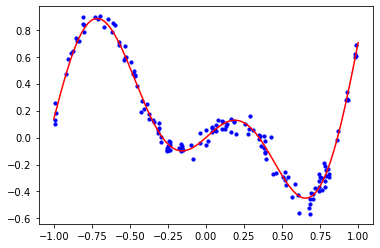

In [3]:
import numpy as np
from matplotlib import pyplot as plt

def transformation_function(x):
    return np.cos(5 * x) * x + .5 * x * np.sin(x)

x = np.linspace(-1, 1, 1000)

plt.plot(x, transformation_function(x), color = 'red')

# In practice, we likely won't actually know the function and need to use data to learn it
# In our analogy, training_x is our sample of low-res images, and training_y is their corresponding high-res images
training_x = np.random.uniform(-1, 1, 150)
# random noise term accounts for the variation between function outputs
random_noise = np.random.normal(scale = 0.05, size = 150)
training_y = transformation_function(training_x) + random_noise

plt.scatter(training_x, training_y, color = 'blue', s = 10)
plt.show()

In [4]:
import tensorflow as tf

# Define a simple neural network
nn_model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(2048, activation='relu', input_shape = (1,)),
  tf.keras.layers.Dense(1024, activation = 'relu'),
  tf.keras.layers.Dense(256, activation = 'relu'),
  tf.keras.layers.Dense(1)
])

nn_model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))

# Train the model
nn_model.fit(training_x, training_y, epochs = 100, verbose = 0)

In [5]:
# Let's generate new data to evaluate whether the neural network led to a good fit
eval_x = np.random.uniform(-1, 1, 250)
predictions = nn_model.predict(eval_x)

eval_x, predictions = zip(*sorted(zip(eval_x, predictions)))

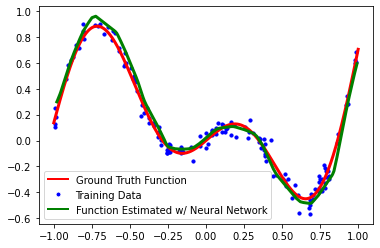

In [6]:
from matplotlib.lines import Line2D

# Plot the results
legend_elements = [Line2D([0], [0], color='r', lw=2, label='Ground Truth Function'),
                   Line2D([0], [0], marker='o', color='w', label='Training Data',
                          markerfacecolor='b', markersize=5),
                   Line2D([0], [0], color='g', lw=2, label='Function Estimated w/ Neural Network')]

fig, ax = plt.subplots()
ax.legend(handles=legend_elements)


plt.plot(x, transformation_function(x), color = 'red', linewidth = 3)
plt.plot(eval_x, predictions, color = 'green', linewidth = 3)
plt.scatter(training_x, training_y, color = 'blue', s = 10)

plt.show()

In the plot above, we can see that our approximation of the underlying function is pretty accurate. This means that we will be able to accurately predict the y-value if our input variable x is within the range of -1 to 1 (the interval in which we trained the neural network). In terms of our computer graphics analogy, this means that if our low-resolution image (x) is similar to other low-resolution images (training_x) in the model's training set, we will have a good idea of what the high-resolution image (y) should look like.


Learning a function that actually models this relationship is much more difficult since the 'transformation_function' will have an n-dimensional input instead of 1-dimensional input as seen in the example. However, this analogy can hopefully help provide some intuition about how AI is able to accomplish such a seemingly impossible task.